# National Park Analysis

In [1]:
#import libraries keys and setup data direcotry
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from datetime import date
import os
import sys
import random
from scipy.stats import linregress
from scipy.stats import normaltest
from citipy import citipy
import json
import gmaps
from math import nan


#Include api directory in path
sys.path.append("api")

# Import API key
from config import g_key
from config import np_key

#National Park Endpoints
np_endpoint_parks = "https://developer.nps.gov/api/v1/parks?"

output_graphs = "data/graphs/"


#DataFrame Descriptions
#attendance_master_detail - National Visit - Location code, activity count - One record per park per year.
#Final_Budget_df - Clean National Park Budget Data - One record per park per year. 
#Max_Year_df - Max Year Visits With location codes -  One record per park. Representing visits from most recent year.
#Budget_Attendance_final_df - Merge of visit, budget (including adjusted for cpi), location codes,state, activity count. One record per year per park.
#National Park activities - One record per activity per national park.  (Just in case, but most likely won't use.)



## Import Park Attendance Data (Ana, Kevin-support)

In [2]:
#Import in park atendnce excel/csv  

In [3]:
# Import the park atendence csv file
attendance_df = pd.read_csv("data/Visists 1979-2019 v2.csv")
attendance_df

,Park Name,Year,Visits
0,Abraham Lincoln Birthplace NHP,2019,238226
1,Abraham Lincoln Birthplace NHP,1979,271231
2,Abraham Lincoln Birthplace NHP,1980,239074
3,Abraham Lincoln Birthplace NHP,1981,252245
4,Abraham Lincoln Birthplace NHP,1982,318707
...,...,...,...
13738,Zion NP,2014,3189696
13739,Zion NP,2015,3648846
13740,Zion NP,2016,4295127
13741,Zion NP,2017,4504812


In [4]:
#Data cleanse.
attendance_df.columns

Index(['Park Name', 'Year', 'Visits'], dtype='object')

In [5]:
#Checking the data types in Data Frame 
attendance_df.dtypes

Park Name    object
Year          int64
Visits        int64
dtype: object

In [6]:
attendance_df["Park Name"] = attendance_df["Park Name"].astype("str")
attendance_df.dtypes

Park Name    object
Year          int64
Visits        int64
dtype: object

In [7]:
# Filter through our attendence DataFrame to fibd only our National Parks
national_park_df = attendance_df[attendance_df["Park Name"].str.contains("NP")]
national_park_df

,Park Name,Year,Visits
41,Acadia NP,2019,3437286
42,Acadia NP,1979,2787366
43,Acadia NP,1980,2779666
44,Acadia NP,1981,2997972
45,Acadia NP,1982,3572114
...,...,...,...
13738,Zion NP,2014,3189696
13739,Zion NP,2015,3648846
13740,Zion NP,2016,4295127
13741,Zion NP,2017,4504812


## Import Operating Cost Data (Kevin)

In [8]:
#Import operating cost into data frame #Import operating cost into data frame 
Budget2006_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2006.xlsx")
Budget2007_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2007.xlsx")
Budget2008_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2008.xlsx")
Budget2009_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2009.xlsx")
Budget2010_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2010.xlsx")
Budget2011_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2011.xlsx")
Budget2012_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2012.xlsx")
Budget2013_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2013.xlsx")
Budget2014_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2014.xlsx")
Budget2015_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2015.xlsx")
Budget2017_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2017.xlsx")
Budget2018_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2018.xlsx")
Budget2019_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2019.xlsx")
Budget2020_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2020.xlsx")
Budget2021_df = pd.read_excel("data/Nation_Park_Budget/National_Park_Budget_2021.xlsx")


In [9]:
#Import operating cost into data frame 
Budget_2002_df = pd.read_excel("data/Budget_Data/2002_Budget.xlsx")
clean_budget_2002_df = Budget_2002_df[Budget_2002_df["National Park Name"].str.contains("NP")]
estimated_budget_2002_df = clean_budget_2002_df.loc[:,("National Park Name","Estimated Budget")]
estimated_budget_2002_df["Year"] = 2002
Budget_2003_df = pd.read_excel("data/Budget_Data/2003_Budget.xlsx")
clean_budget_2003_df = Budget_2003_df[Budget_2003_df["National Park Name"].str.contains("NP")]
estimated_budget_2003_df = clean_budget_2003_df.loc[:,("National Park Name","Estimated Budget")]
estimated_budget_2003_df["Year"] = 2003
Budget_2004_df = pd.read_excel("data/Budget_Data/2004_Budget.xlsx")
clean_budget_2004_df = Budget_2004_df[Budget_2004_df["National Park Name"].str.contains("NP")]
estimated_budget_2004_df = clean_budget_2004_df.loc[:,("National Park Name","Estimated Budget")]
estimated_budget_2004_df["Year"] = 2004
Budget_2005_df = pd.read_excel("data/Budget_Data/2005_Budget.xlsx")
clean_budget_2005_df = Budget_2005_df[Budget_2005_df["National Park Name"].str.contains("NP")]
estimated_budget_2005_df = clean_budget_2005_df.loc[:,("National Park Name","Estimated Budget")]
estimated_budget_2005_df["Year"] = 2005
Budget_2016_df = pd.read_excel("data/Budget_Data/2016_Budget.xlsx")
clean_budget_2016_df = Budget_2016_df[Budget_2016_df["National Park Name"].str.contains("NP")]
estimated_budget_2016_df = clean_budget_2016_df.loc[:,("National Park Name","Estimated Budget")]
estimated_budget_2016_df["Year"] = 2016
# Renaming Budget to Match Kevin's set
# Clean_Budget2006_df = Clean_Budget2006_df.rename(columns={"OPERATION OF THE NAT'L PARK SYSTEM":"Park Name","FY 2006 Presiden's Request":"Budget Request(dollars in thousands)"})
renamedestimated_budget_2002_df=estimated_budget_2002_df.rename(columns={"National Park Name":"Park Name","Estimated Budget":"Budget Request(dollars in thousands)"})
renamedestimated_budget_2003_df=estimated_budget_2003_df.rename(columns={"National Park Name":"Park Name","Estimated Budget":"Budget Request(dollars in thousands)"})
renamedestimated_budget_2004_df=estimated_budget_2004_df.rename(columns={"National Park Name":"Park Name","Estimated Budget":"Budget Request(dollars in thousands)"})
renamedestimated_budget_2005_df=estimated_budget_2005_df.rename(columns={"National Park Name":"Park Name","Estimated Budget":"Budget Request(dollars in thousands)"})
renamedestimated_budget_2016_df=estimated_budget_2016_df.rename(columns={"National Park Name":"Park Name","Estimated Budget":"Budget Request(dollars in thousands)"})



In [10]:
#Data cleansing
Clean_Budget2006_df = Budget2006_df.loc[:,["OPERATION OF THE NAT'L PARK SYSTEM","FY 2006 Presiden's Request"]]
Clean_Budget2007_df = Budget2007_df.loc[:,["OPERATION OF THE NAT'L PARK SYSTEM","FY 2007 Request"]]
Clean_Budget2008_df = Budget2008_df.loc[:,["OPERATION OF THE NAT'L PARK SYSTEM","FY 2008 President's Request"]]
Clean_Budget2009_df = Budget2009_df.loc[:,["Operation of National Park System","FY 2009 Presidents Request"]]
Clean_Budget2010_df = Budget2010_df.loc[:,["Operation of Nat Park","FY 2010 Preisdent Request"]]
Clean_Budget2011_df = Budget2011_df.loc[:,["Operation of The National Park System","FY 2011 President's Request"]]
Clean_Budget2012_df = Budget2012_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM","2012 Presidents Requests"]]
Clean_Budget2013_df = Budget2013_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM","FY 2013 Presidents Request"]]
Clean_Budget2014_df = Budget2014_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM","2014 Requested"]]
Clean_Budget2015_df = Budget2015_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM","2015 Reques t"]]
Clean_Budget2017_df = Budget2017_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM","FY 2017 Request"]]
Clean_Budget2018_df = Budget2018_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM\nORGANIZATIONS","FY 2018\nRequest"]]
Clean_Budget2019_df = Budget2019_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM ORGANIZATIONS","FY 2019\nRequest9"]]
Clean_Budget2021_df = Budget2021_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM ORGANIZATIONS", " FY 2021\nRequest"]]
Clean_Budget2020_df = Budget2020_df.loc[:,["OPERATION OF THE NATIONAL PARK SYSTEM ORGANIZATIONS ", "FY 2020 Request "]]

In [11]:
# Adding New Column For Year
Clean_Budget2006_df["Year"]=2006
Clean_Budget2007_df["Year"]=2007
Clean_Budget2008_df["Year"]=2008
Clean_Budget2009_df["Year"]=2009
Clean_Budget2010_df["Year"]=2010
Clean_Budget2011_df["Year"]=2011
Clean_Budget2012_df["Year"]=2012
Clean_Budget2013_df["Year"]=2013
Clean_Budget2014_df["Year"]=2014
Clean_Budget2015_df["Year"]=2015
Clean_Budget2017_df["Year"]=2017
Clean_Budget2018_df["Year"]=2018
Clean_Budget2019_df["Year"]=2019
Clean_Budget2020_df["Year"]=2020
Clean_Budget2021_df["Year"]=2021

In [12]:
# Making the Same name for the columns from different years
Clean_Budget2006_df = Clean_Budget2006_df.rename(columns={"OPERATION OF THE NAT'L PARK SYSTEM":"Park Name","FY 2006 Presiden's Request":"Budget Request(dollars in thousands)"})
Clean_Budget2007_df = Clean_Budget2007_df.rename(columns={"OPERATION OF THE NAT'L PARK SYSTEM":"Park Name","FY 2007 Request":"Budget Request(dollars in thousands)"})
Clean_Budget2008_df = Clean_Budget2008_df.rename(columns={"OPERATION OF THE NAT'L PARK SYSTEM":"Park Name","FY 2008 President's Request":"Budget Request(dollars in thousands)"})
Clean_Budget2009_df = Clean_Budget2009_df.rename(columns={"Operation of National Park System":"Park Name","FY 2009 Presidents Request":"Budget Request(dollars in thousands)"})
Clean_Budget2010_df = Clean_Budget2010_df.rename(columns={"Operation of Nat Park":"Park Name","FY 2010 Preisdent Request":"Budget Request(dollars in thousands)"})
Clean_Budget2011_df = Clean_Budget2011_df.rename(columns={"Operation of The National Park System":"Park Name","FY 2011 President's Request":"Budget Request(dollars in thousands)"})
Clean_Budget2012_df = Clean_Budget2012_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM":"Park Name","2012 Presidents Requests":"Budget Request(dollars in thousands)"})
Clean_Budget2013_df = Clean_Budget2013_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM":"Park Name","FY 2013 Presidents Request":"Budget Request(dollars in thousands)"})
Clean_Budget2014_df = Clean_Budget2014_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM":"Park Name","2014 Requested":"Budget Request(dollars in thousands)"})
Clean_Budget2015_df = Clean_Budget2015_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM":"Park Name","2015 Reques t":"Budget Request(dollars in thousands)"})
Clean_Budget2017_df = Clean_Budget2017_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM":"Park Name","FY 2017 Request":"Budget Request(dollars in thousands)"})
Clean_Budget2018_df = Clean_Budget2018_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM\nORGANIZATIONS":"Park Name","FY 2018\nRequest":"Budget Request(dollars in thousands)"})
Clean_Budget2019_df = Clean_Budget2019_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM ORGANIZATIONS":"Park Name","FY 2019\nRequest9":"Budget Request(dollars in thousands)"})
Clean_Budget2021_df = Clean_Budget2021_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM ORGANIZATIONS":"Park Name", " FY 2021\nRequest":"Budget Request(dollars in thousands)"})
Clean_Budget2020_df = Clean_Budget2020_df.rename(columns={"OPERATION OF THE NATIONAL PARK SYSTEM ORGANIZATIONS ":"Park Name", "FY 2020 Request ":"Budget Request(dollars in thousands)"})

In [13]:
# Merge, drop NA, then look for only NP
Frames  = [renamedestimated_budget_2002_df, renamedestimated_budget_2003_df, renamedestimated_budget_2004_df, renamedestimated_budget_2005_df,renamedestimated_budget_2016_df,Clean_Budget2006_df,Clean_Budget2007_df,Clean_Budget2008_df,Clean_Budget2009_df, Clean_Budget2010_df,Clean_Budget2011_df, Clean_Budget2012_df,Clean_Budget2013_df, Clean_Budget2014_df,Clean_Budget2015_df, Clean_Budget2021_df,Clean_Budget2017_df, Clean_Budget2018_df,Clean_Budget2019_df, Clean_Budget2020_df]
Total_Budget_df= pd.concat(Frames)
Total_Budget_df.dropna( inplace=True )
Final_Budget_df = Total_Budget_df[Total_Budget_df["Park Name"].str.contains("NP")]
# Added by Mike to change from object type to int
Final_Budget_df["Budget Request(dollars in thousands)"] = Final_Budget_df["Budget Request(dollars in thousands)"].astype("int64")
Final_Budget_df



<ipython-input-13-b3e73675b208>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_Budget_df["Budget Request(dollars in thousands)"] = Final_Budget_df["Budget Request(dollars in thousands)"].astype("int64")


,Park Name,Budget Request(dollars in thousands),Year
1,Acadia NP,4706000,2002
12,Arches NP,1020000,2002
17,Badlands NP,3072000,2002
21,Big Bend NP,4735000,2002
27,Biscayne NP,3480000,2002
...,...,...,...
353,Wrangell-Saint Elias NP&Pres,5634,2020
354,Yellowstone NP,34410,2020
355,Yosemite NP,30032,2020
357,Yukon-Charley Rivers NPres,1768,2020


In [14]:
Final_Budget_df.dtypes

Park Name                               object
Budget Request(dollars in thousands)     int64
Year                                     int64
dtype: object

## Import CPI table

In [15]:
cpi_df = pd.read_excel("data/cpi_table.xlsx")

In [16]:
cpi_df


,YEAR,CPI
0,2020,258.811
1,2019,255.657
2,2018,251.107
3,2017,245.120
4,2016,240.008
5,2015,237.017
6,2014,236.736
7,2013,232.957
8,2012,229.594
9,2011,224.939


## CPI Function

In [17]:

#The following function will return adjusted prior year abount based on CPI of current year and prior year.

def cpi_fnc ( current_year,prior_year, prior_amount ):
    
    ret_val = 0
    if type(prior_year) != 'int' or  type(current_year) != 'int':
        try:
            prior_year = int(prior_year)
            current_year = int(current_year)
        except:
            print(f"Type Error: Make sure to pass int values or strings that will convert to int")
        if len(cpi_df[cpi_df["YEAR"] == prior_year]) == 0:
                  print(f"Year {str(prior_year)} does not exist in CPI table")
        elif len(cpi_df[cpi_df["YEAR"] == current_year]) == 0:
                  print(f"Year {str(current_year)} does not exist in CPI table")
        else:
            v_curr_year_cpi = cpi_df[cpi_df["YEAR"] == current_year]["CPI"].values[0]
            v_prior_year_cpi = cpi_df[cpi_df["YEAR"] == prior_year]["CPI"].values[0]          
            adjusted_amount = prior_amount * float((v_curr_year_cpi/v_prior_year_cpi))
            ret_val = round(adjusted_amount,2)
    return ret_val
                

In [18]:
#CPI Test Statement

x = cpi_fnc(2020,2000,14888023)
print(str(x))


22376214.41


## Add CPI Adjusted Budget Amount columns to budget tables (Mike - Efrain)

In [19]:
#Add Column Adjusted Budget Column for 2020 CPI

Final_Budget_df["AdjBudg(dollars in thousands)"] = 0

for index, row in Final_Budget_df.iterrows():
    Final_Budget_df.loc[index,"AdjBudg(dollars in thousands)"] = cpi_fnc ( 2020, row["Year"], row["Budget Request(dollars in thousands)"])

    

<ipython-input-19-225983219abe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_Budget_df["AdjBudg(dollars in thousands)"] = 0
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 does not exist in CPI table
Year 2021 do

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

## Geo Code Park Attendance Data Frame(Mike, Anna-support)

In [20]:
#Geocode work.  Utilizing existing Attendance 
np_master_df =pd.read_csv("data/national_park_master.csv")
np_master_df 

,parkCode,fullName,lat,lon,Park Name
0,acad,Acadia National Park,44.409286,-68.247501,Acadia NP
1,arch,Arches National Park,38.722618,-109.586367,Arches NP
2,badl,Badlands National Park,43.685848,-102.482942,Badlands NP
3,bibe,Big Bend National Park,29.298178,-103.229790,Big Bend NP
4,bisc,Biscayne National Park,25.490587,-80.210239,Biscayne NP
5,blca,Black Canyon Of The Gunnison National Park,38.577799,-107.724276,Black Canyon of the Gunnison NP
6,brca,Bryce Canyon National Park,37.583991,-112.182669,Bryce Canyon NP
7,cany,Canyonlands National Park,38.245558,-109.880162,Canyonlands NP
8,care,Capitol Reef National Park,38.282165,-111.247048,Capitol Reef NP
9,cave,Carlsbad Caverns National Park,32.140895,-104.552969,Carlsbad Caverns NP


In [21]:
#Connect to NP API parks endpoint to get park state and activities
parkCode_list = []
activities_list = []
np_master_df["State"] = " "
np_master_df["Activity Count"] = 0

for index, row in np_master_df.iterrows():
    params = { "api_key": np_key,
               "parkCode":row["parkCode"]
             }
    response = requests.get(np_endpoint_parks,params).json()
    if len(response["data"][0]["addresses"]) > 0:
        np_master_df.loc[index,"State"] = response["data"][0]["addresses"][0]["stateCode"]
    np_master_df.loc[index,"Activity Count"] = len(response["data"][0]["activities"])
    for activity in response["data"][0]["activities"]:
        parkCode_list.append(row["parkCode"])
        activities_list.append(activity["name"])
        
    

    



In [22]:
#Build NP Activities List
np_activities = pd.DataFrame ({"parkCode":parkCode_list, "Activity":activities_list})

#Build Park Activies DataFrame
np_activities_df = pd.DataFrame ({"parkCode":parkCode_list, "Activity":activities_list})
np_activities_df["Cnt"] = 1

#Pivot on parkCode Not working
#np_activities_pivot_df = pd.pivot(np_activities_df,index="parkCode", columns = "Activity", values = "Cnt").reset_index()



In [23]:
np_activities

,parkCode,Activity
0,acad,Arts and Culture
1,acad,Cultural Demonstrations
2,acad,Astronomy
3,acad,Stargazing
4,acad,Biking
...,...,...
1541,zion,Birdwatching
1542,zion,Park Film
1543,zion,Museum Exhibits
1544,zion,Shopping


In [24]:
np_master_df

,parkCode,fullName,lat,lon,Park Name,State,Activity Count
0,acad,Acadia National Park,44.409286,-68.247501,Acadia NP,ME,46
1,arch,Arches National Park,38.722618,-109.586367,Arches NP,UT,20
2,badl,Badlands National Park,43.685848,-102.482942,Badlands NP,SD,21
3,bibe,Big Bend National Park,29.298178,-103.229790,Big Bend NP,TX,19
4,bisc,Biscayne National Park,25.490587,-80.210239,Biscayne NP,FL,13
5,blca,Black Canyon Of The Gunnison National Park,38.577799,-107.724276,Black Canyon of the Gunnison NP,CO,13
6,brca,Bryce Canyon National Park,37.583991,-112.182669,Bryce Canyon NP,UT,28
7,cany,Canyonlands National Park,38.245558,-109.880162,Canyonlands NP,UT,23
8,care,Capitol Reef National Park,38.282165,-111.247048,Capitol Reef NP,UT,47
9,cave,Carlsbad Caverns National Park,32.140895,-104.552969,Carlsbad Caverns NP,NM,21


In [25]:
#creating data frame joining master table and detail visists
#attendance_master_detail = pd.concat([national_park_df,np_master_df],join="inner",keys=["Park Name"],axis=1)

attendance_master_detail = pd.merge(Final_Budget_df, np_master_df, how="inner", on=["Park Name"])

In [26]:
attendance_master_detail.head(-10)

,Park Name,Budget Request(dollars in thousands),Year,AdjBudg(dollars in thousands),parkCode,fullName,lat,lon,State,Activity Count
0,Acadia NP,4706000,2002,7920.00,acad,Acadia National Park,44.409286,-68.247501,ME,46
1,Acadia NP,5686,2003,7920.00,acad,Acadia National Park,44.409286,-68.247501,ME,46
2,Acadia NP,6415,2004,7920.00,acad,Acadia National Park,44.409286,-68.247501,ME,46
3,Acadia NP,6277,2005,7920.00,acad,Acadia National Park,44.409286,-68.247501,ME,46
4,Acadia NP,8130,2016,7920.00,acad,Acadia National Park,44.409286,-68.247501,ME,46
...,...,...,...,...,...,...,...,...,...,...
777,Congaree NP,1641,2006,1972.61,cong,Congaree National Park,33.791875,-80.748678,SC,26
778,Congaree NP,1218,2007,2053.12,cong,Congaree National Park,33.791875,-80.748678,SC,26
779,Congaree NP,1641,2008,1972.61,cong,Congaree National Park,33.791875,-80.748678,SC,26
780,Congaree NP,1900,2009,1724.01,cong,Congaree National Park,33.791875,-80.748678,SC,26


In [27]:
#Max_Year_attendance_df = attendence_df[attendence_df["Park Name"].str.contains("NP")]
#Max_Year_attendance_df

Max_Year_attendance_grp = attendance_master_detail.groupby(['Park Name'])['Year'].max()
Max_Year_attendance_stg_df = Max_Year_attendance_grp.reset_index()
#attendance_master_detail[attendance_master_detail['Year']==Max_Year_attendance_stg_df['Year']
                        
#Max_Year_attendance_df


In [28]:
Max_Year_attendance_stg_df

,Park Name,Year
0,Acadia NP,2019
1,Arches NP,2019
2,Badlands NP,2019
3,Big Bend NP,2019
4,Biscayne NP,2019
5,Black Canyon of the Gunnison NP,2019
6,Bryce Canyon NP,2019
7,Canyonlands NP,2019
8,Capitol Reef NP,2019
9,Carlsbad Caverns NP,2019


In [29]:

Max_Year_stg_df = pd.merge(Max_Year_attendance_stg_df, np_master_df, how="inner", on=["Park Name"])

Max_Year_df = pd.merge(Max_Year_stg_df,national_park_df,how="inner", on=["Park Name","Year"])
Max_Year_df

,Park Name,Year,parkCode,fullName,lat,lon,State,Activity Count,Visits
0,Acadia NP,2019,acad,Acadia National Park,44.409286,-68.247501,ME,46,3437286
1,Arches NP,2019,arch,Arches National Park,38.722618,-109.586367,UT,20,1659702
2,Badlands NP,2019,badl,Badlands National Park,43.685848,-102.482942,SD,21,970998
3,Big Bend NP,2019,bibe,Big Bend National Park,29.298178,-103.229790,TX,19,463832
4,Biscayne NP,2019,bisc,Biscayne National Park,25.490587,-80.210239,FL,13,708522
5,Black Canyon of the Gunnison NP,2019,blca,Black Canyon Of The Gunnison National Park,38.577799,-107.724276,CO,13,432818
6,Bryce Canyon NP,2019,brca,Bryce Canyon National Park,37.583991,-112.182669,UT,28,2594904
7,Canyonlands NP,2019,cany,Canyonlands National Park,38.245558,-109.880162,UT,23,733996
8,Capitol Reef NP,2019,care,Capitol Reef National Park,38.282165,-111.247048,UT,47,1226519
9,Carlsbad Caverns NP,2019,cave,Carlsbad Caverns National Park,32.140895,-104.552969,NM,21,440691


In [30]:
## Merge Data add Custom fields (Efrain, Kevin, Ana)

In [31]:
# Merge data frames add 

In [32]:
 #Create any custom fields needed to partition data for analysis

In [33]:
#Duplicate all monetary fieldfs adjusting for inflation

# # Join Attendance Detail to Budget

In [34]:
#Merge 
Budget_Attendance_final_df = pd.merge(Final_Budget_df, national_park_df, how="inner", on=["Park Name","Year"])
Budget_Attendance_final_df = pd.merge(Budget_Attendance_final_df,np_master_df,how="inner", on=["Park Name"])

## Create Current Year Summary Attendance Statistics (Ana - Mike Support)

In [35]:
# Top 10 by visit 2019

#Max_Year_df.groupby(["Park Name","Year","Visits"]).size().sort_values(ascending=False)

#Max_Year_df.sort_values('Visits', ascending=False).head(10)

Max_Year_df[["Park Name","Year","Visits"]].sort_values(by=["Visits"],ascending=False).head(10)

,Park Name,Year,Visits
21,Great Smoky Mountains NP,2019,12547743
18,Grand Canyon NP,2019,5974411
36,Rocky Mountain NP,2019,4670053
45,Zion NP,2019,4488268
44,Yosemite NP,2019,4422861
43,Yellowstone NP,2019,4020288
0,Acadia NP,2019,3437286
19,Grand Teton NP,2019,3405614
33,Olympic NP,2019,3245806
17,Glacier NP,2019,3049839


In [36]:
#Top 10 least visited Parks for 2019
Max_Year_df[["Park Name","Year","Visits"]].sort_values(by=["Visits"]).head(10)

,Park Name,Year,Visits
26,Isle Royale NP,2019,26410
15,Dry Tortugas NP,2019,79200
20,Great Basin NP,2019,131802
40,Virgin Islands NP,2019,133398
11,Congaree NP,2019,159445
35,Pinnacles NP,2019,177224
22,Guadalupe Mountains NP,2019,188833
41,Voyageurs NP,2019,232974
28,Kenai Fjords NP,2019,356601
10,Channel Islands NP,2019,409630


In [37]:
#Addded 2/7/2021 By Mike  Summary Parks, Visits By Year  Data check
attendance_master_summ_df = national_park_df.groupby(by=["Year"]).agg({"Park Name":"count",
                                                                          "Visits":"sum"}).reset_index()
attendance_master_summ_df.sort_values(by="Year")

,Year,Park Name,Visits
0,1979,56,53194116
1,1980,56,54540968
2,1981,57,57774669
3,1982,64,57794412
4,1983,64,58788866
5,1984,65,57730578
6,1985,66,58832628
7,1986,66,62988481
8,1987,66,66252443
9,1988,66,66748736


In [38]:
Max_Year_df
locations= Max_Year_df[['lat', 'lon']].astype(float)
locations

,lat,lon
0,44.409286,-68.247501
1,38.722618,-109.586367
2,43.685848,-102.482942
3,29.298178,-103.229790
4,25.490587,-80.210239
5,38.577799,-107.724276
6,37.583991,-112.182669
7,38.245558,-109.880162
8,38.282165,-111.247048
9,32.140895,-104.552969


In [39]:
#Heat Map All National parks parks.  Intensity = Visits
#attendance_master_detail.head()



gmaps.configure(api_key=g_key)
# Store 'Lat' and 'Lng' into  locations 
locations= Max_Year_df[['lat', 'lon']].astype(float)
#weights=Max_Year_df['Visits'].astype(float)
# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
#census_data_complete = census_data_complete.dropna()
visits_all = Max_Year_df["Visits"].astype(float)
max_visits = Max_Year_df["Visits"].max() 
#max_visits= Max_Year_df["Visits"].max()

# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=visits_all, 
                                 dissipating=False, max_intensity=max_visits,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Create Heat Maps to Visualize Cost and Attendance (Kevin -  Mike support)

In [40]:
## Heat Map By Operating Costs

In [41]:
##Heat Map by Attendance

## Scater/Line Plots Operating Costs versus Attendance (Ana and Efrain)  Be creative 

Text(0, 0.5, 'Visits')

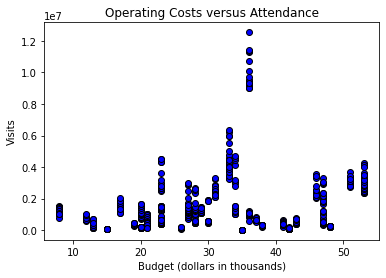

In [42]:
Analysis=Budget_Attendance_final_df.loc[:,["AdjBudg(dollars in thousands)","Visits","Activity Count", "Park Name", "Year"]]
Analysis
Activity_Count = Analysis["Activity Count"].values.tolist()
Budget = Analysis["Activity Count"].values.tolist()
Visits = Analysis["Visits"].values.tolist()
Year=Analysis["Year"].values.tolist()
# Budget, =plt.plot(Year,Budget, color = "green", label= "Visits")
# Attendance, =plt.plot(Year,Visits, color = "red", label= "Visits")
Operation =plt.scatter(Budget,Visits, color = "blue", label= "Visits",edgecolors="black")
# plt.xlim(2005,2022)
# plt.ylim(5,11000)
plt.title("Operating Costs versus Attendance")
plt.xlabel("Budget (dollars in thousands)")
plt.ylabel("Visits")


In [43]:
Hist_data=Analysis.query('Year == "2019"')
Hist_data
group=Hist_data.groupby(["Park Name"]).head()
group
TopActivities=group.sort_values(by=["Activity Count"],ascending=False).head(10)
TopCost=group.sort_values(by=["AdjBudg(dollars in thousands)"],ascending=False).head(10)
TopVisit=group.sort_values(by=["Visits"],ascending=False).head(10)
Histograms  = [TopVisit,TopCost,TopActivities]
Master_Top_10= pd.concat(Histograms)
Clean_Master=Master_Top_10.sort_values(by=["Park Name"],ascending=False).drop_duplicates()
Finalact=Clean_Master["Activity Count"].values.tolist()
Finalbud=Clean_Master["AdjBudg(dollars in thousands)"].values.tolist()
Clean_Visit=Clean_Master['Visits'].values.tolist()
name=Clean_Master['Park Name'].values.tolist()
data= [[name,Clean_Visit,Finalbud,Finalact]]
# Clean_Master.plot.bar(title="test").legend(loc=1)

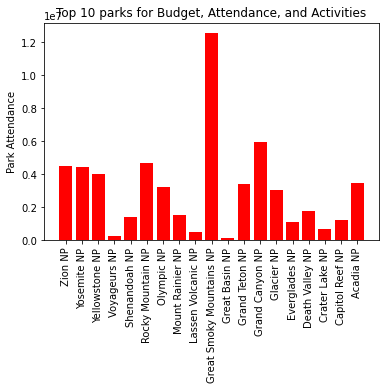

In [44]:
plt.bar(name,Clean_Visit, color="r")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Top 10 parks for Budget, Attendance, and Activities")
plt.ylabel("Park Attendance")
plt.show()

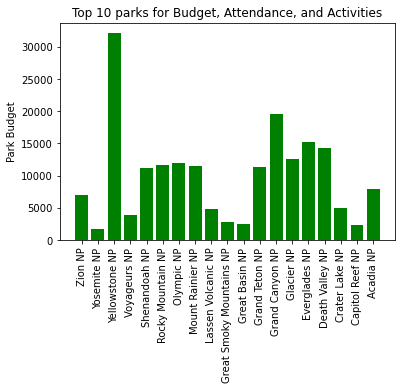

In [45]:
plt.bar(name,Finalbud, color="g")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Top 10 parks for Budget, Attendance, and Activities")
plt.ylabel("Park Budget")
plt.show()

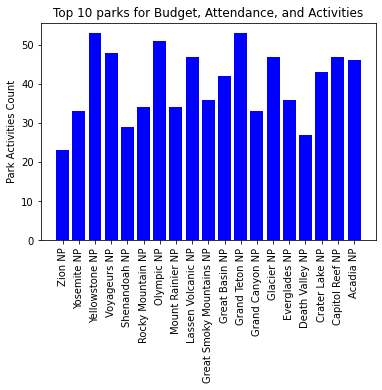

In [46]:
plt.bar(name,Finalact, color="b")
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Top 10 parks for Budget, Attendance, and Activities")
plt.ylabel("Park Activities Count")
plt.show()
plt.show()

## Trend Analysis (Compare Productivity Year Over Year) Mike and Kevin

In [47]:
#Graph Park Name vs Budget over time
Budget2021=Final_Budget_df.query('Year == "2021"')
Ten_Most_Expensive2021=Budget2021[["Park Name", "AdjBudg(dollars in thousands)", "Year"]].sort_values(by=["AdjBudg(dollars in thousands)"],ascending=False).head(10)
Ten_Most_Expensive2021

,Park Name,AdjBudg(dollars in thousands),Year
366,West. Arctic Parklands - Bering Land Bridge NP...,34373.18,2021
355,Valles Caldera NPres,30032.00,2021
143,Grand Canyon NP,20990.00,2021
150,Great Basin NP,18888.00,2021
153,Great Smoky Mountains NP,18862.48,2021
97,Everglades NP,16393.00,2021
84,Denali NP&Pres,14240.00,2021
138,Glacier NP,13453.00,2021
304,Rocky Mountain NP,11931.00,2021
79,Cuyahoga Valley NP,10586.00,2021


No handles with labels found to put in legend.


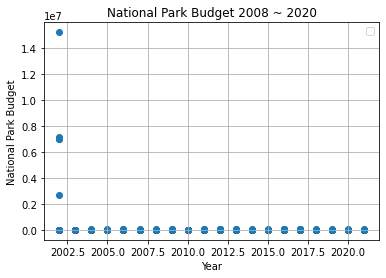

In [48]:
Scatter_df=Final_Budget_df.loc[:,["Park Name", "AdjBudg(dollars in thousands)", "Year"]]
Park_Name=Scatter_df["Park Name"]
Adjusted_Budget=Scatter_df["AdjBudg(dollars in thousands)"]
Year=Scatter_df["Year"]
plt.scatter(Year, Adjusted_Budget)
plt.grid()
plt.title("National Park Budget 2008 ~ 2020")
plt.xlabel("Year")
plt.ylabel("National Park Budget")
plt.legend()
plt.show()

In [49]:
Clean_Budget2008_df["Budget Request(dollars in thousands)"].sum()

1159907.0

## Productivity Calculations

In [50]:
#Productivity is measured as Visits/Per Dollars spent in thousands
#Productivity at park/year grain
Productivity_det_df = Budget_Attendance_final_df
Productivity_det_df["Prod (Visits Per Thousand Dollars)"] = round(Productivity_det_df["Visits"] / Productivity_det_df["AdjBudg(dollars in thousands)"],2)

#Build Productivity for all parks 
Productivity_summ_groupby = Budget_Attendance_final_df.groupby(by=["Year"])

Productivity_summ_df  = Productivity_summ_groupby["Visits","AdjBudg(dollars in thousands)"].sum().reset_index()
Productivity_summ_df["Prod (Visits Per Thousand Dollars)"] = round(Productivity_summ_df["Visits"] / Productivity_summ_df["AdjBudg(dollars in thousands)"],2)



<ipython-input-50-519822f85ad0>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Productivity_summ_df  = Productivity_summ_groupby["Visits","AdjBudg(dollars in thousands)"].sum().reset_index()


<BarContainer object of 18 artists>

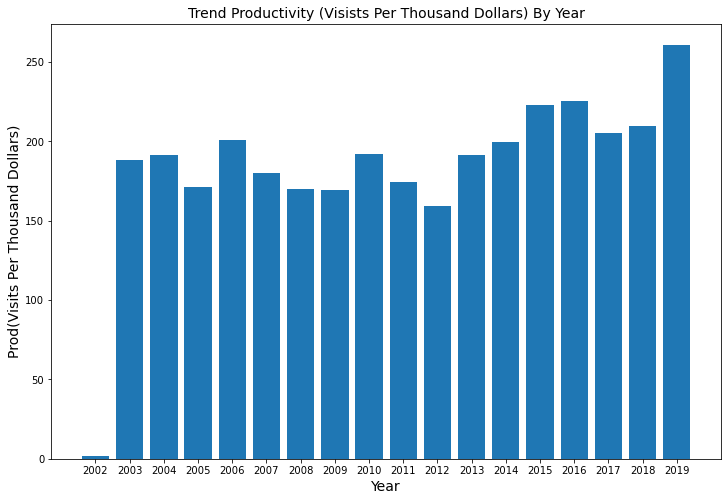

In [56]:
plt.figure(figsize=(12,8))
plt.xticks(Productivity_summ_df["Year"])
plt.ylabel("Prod(Visits Per Thousand Dollars)",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.title("Trend Productivity (Visists Per Thousand Dollars) By Year",fontsize=14)
plt.bar(Productivity_summ_df["Year"], Productivity_summ_df["Prod (Visits Per Thousand Dollars)"],width=.8)

<ipython-input-59-26e531046a23>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig.figure(figsize=(11,6))
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base

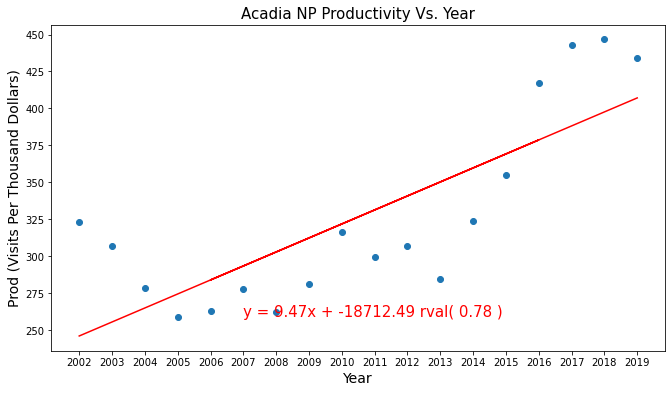

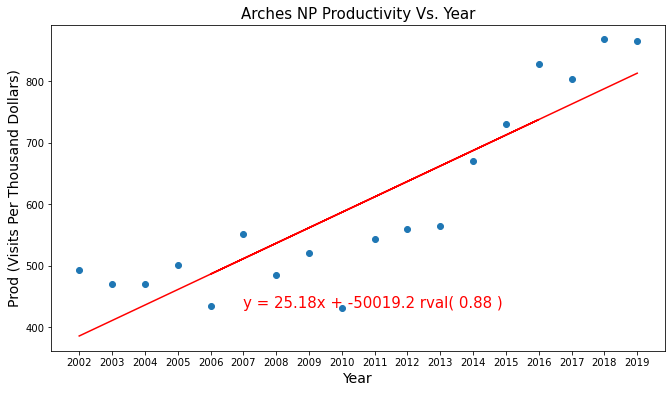

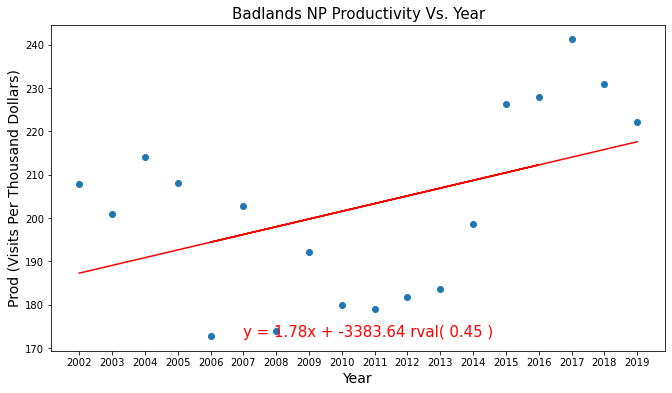

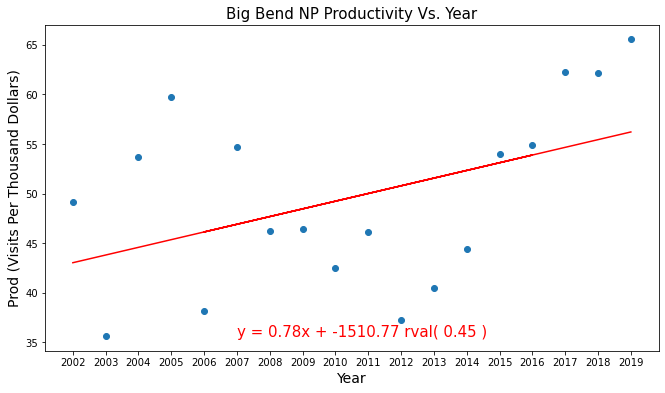

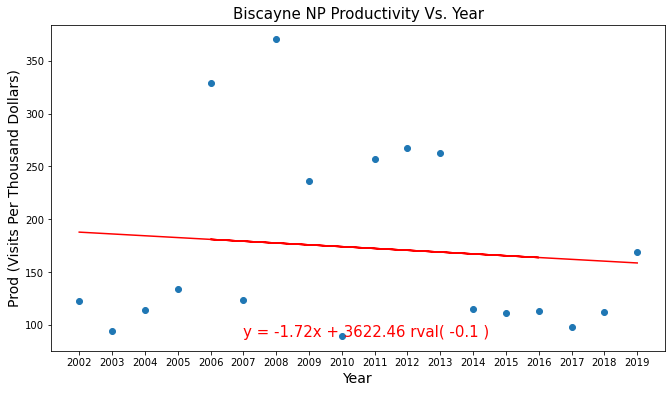

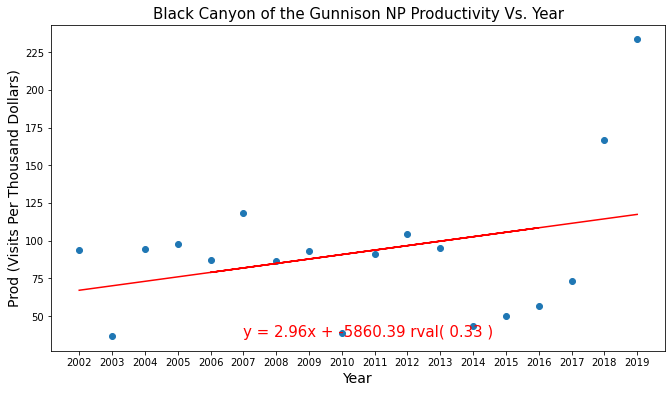

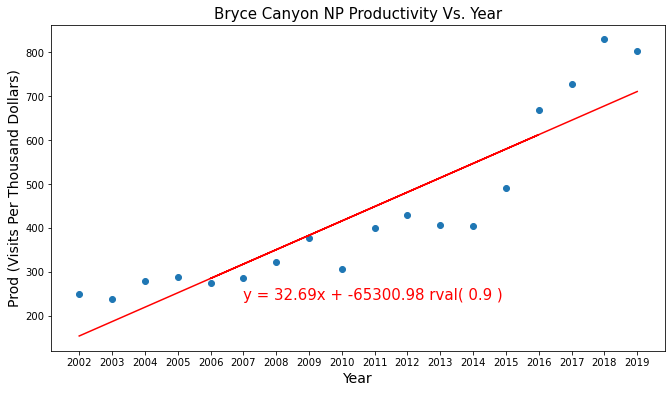

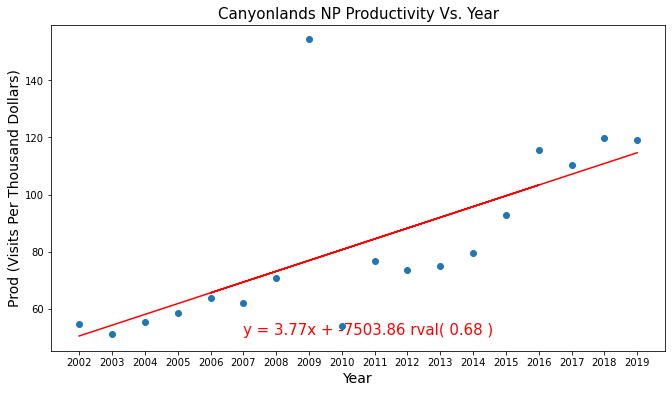

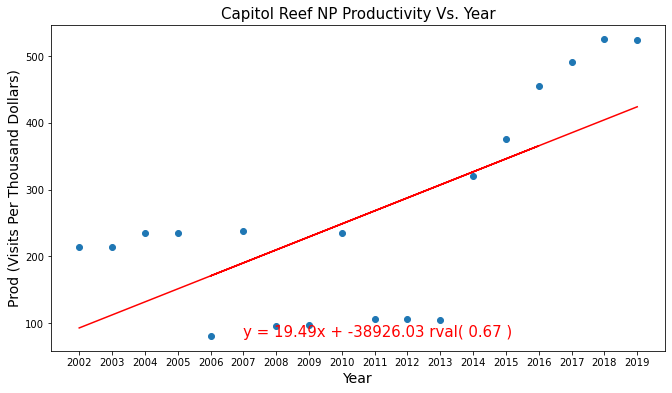

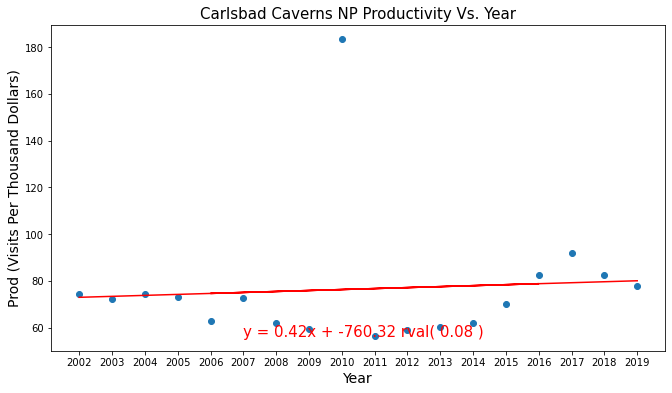

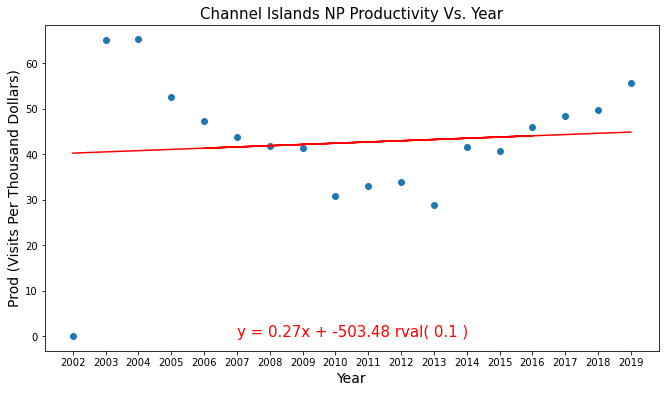

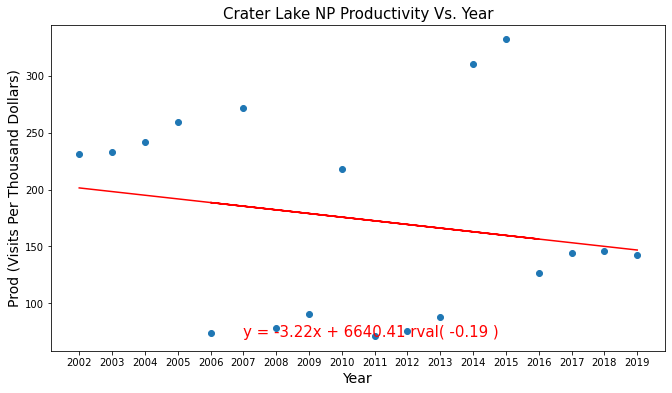

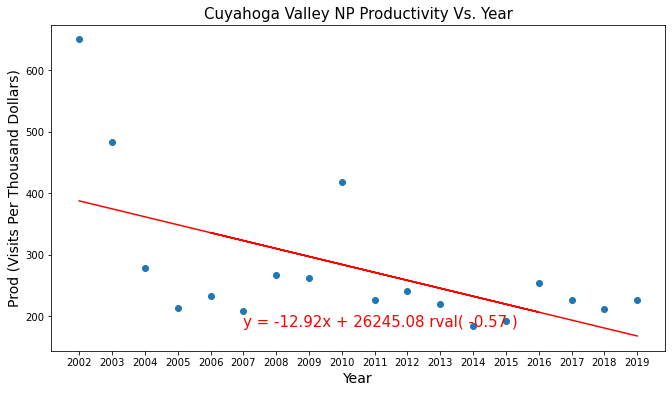

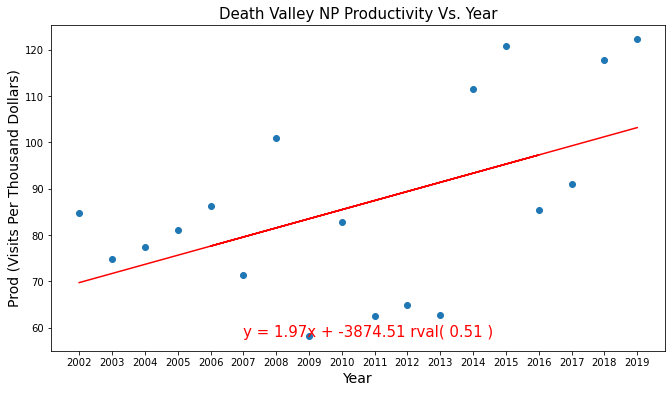

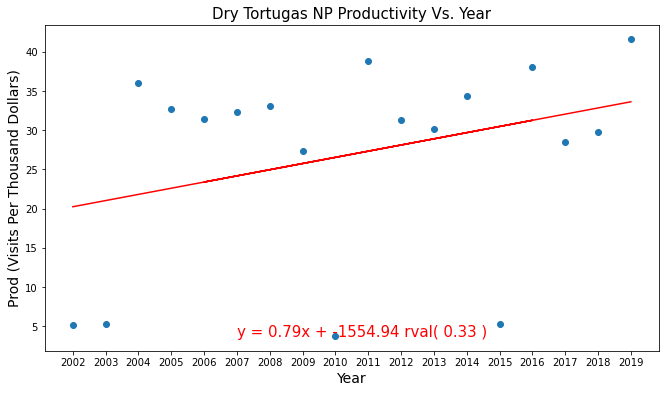

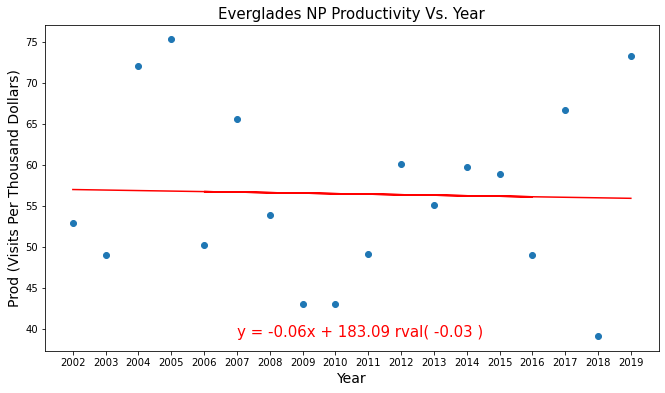

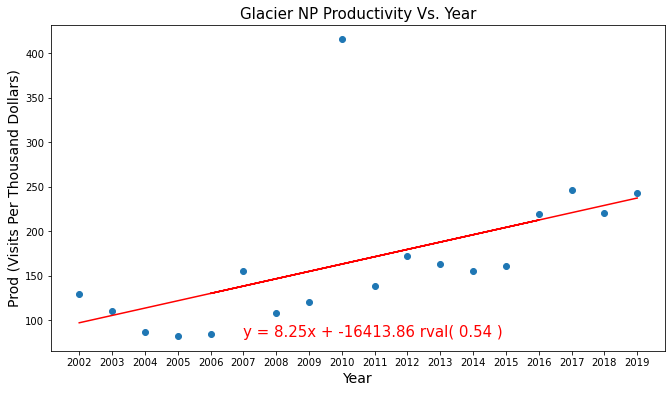

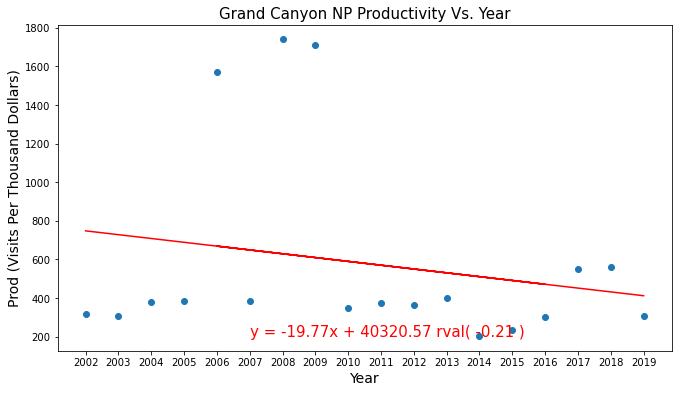

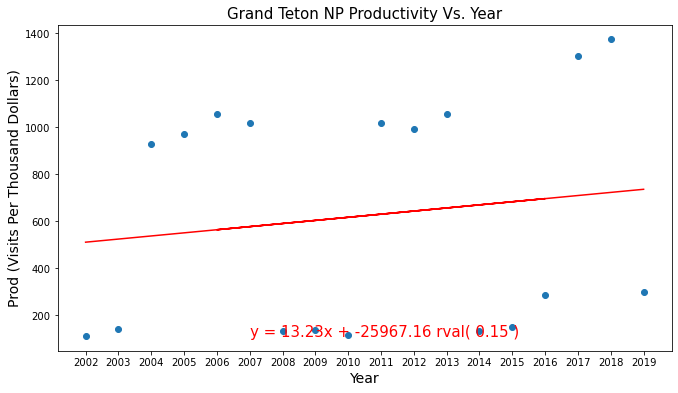

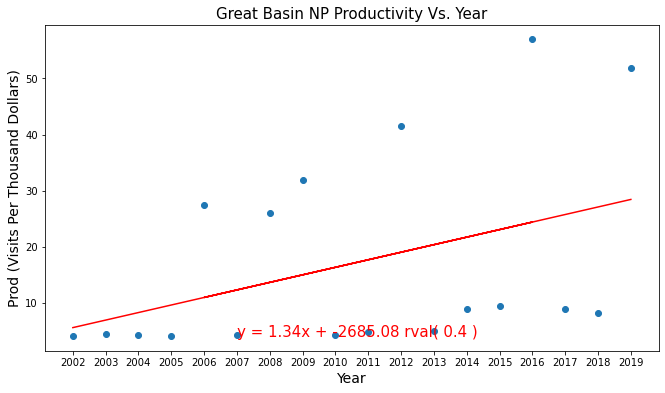

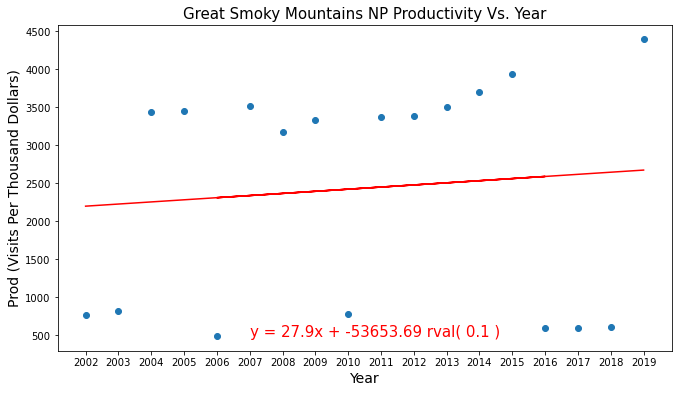

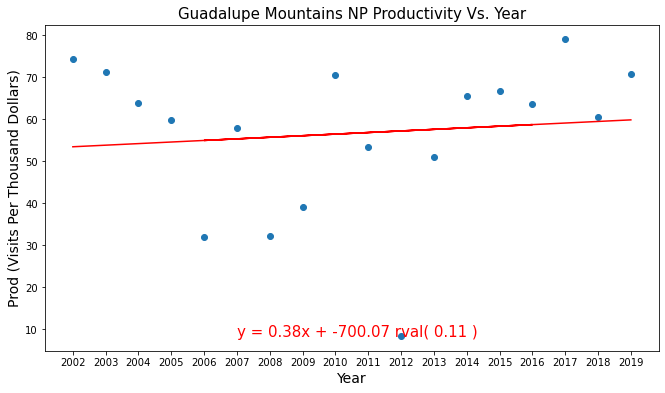

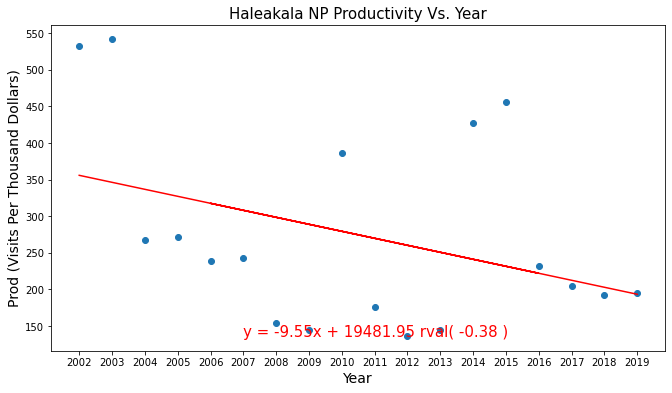

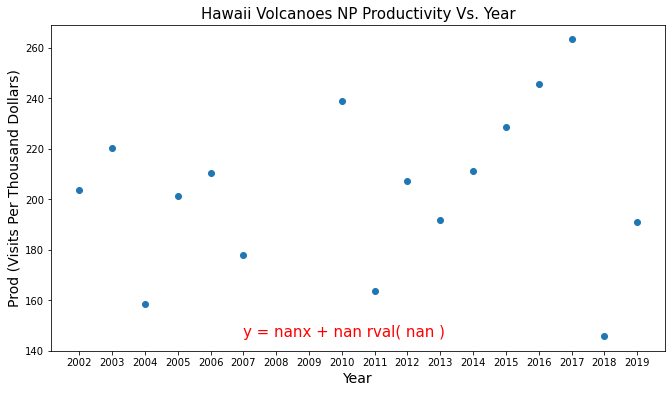

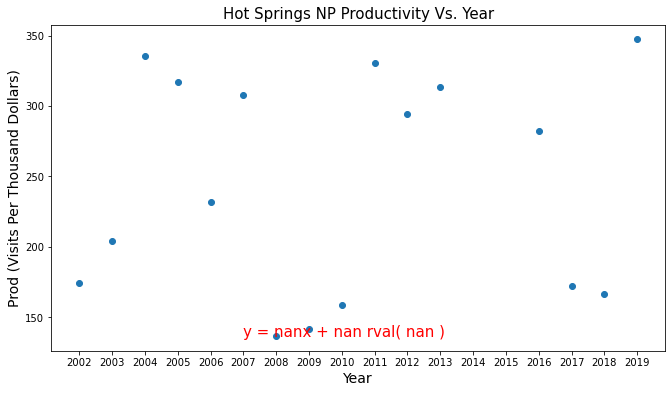

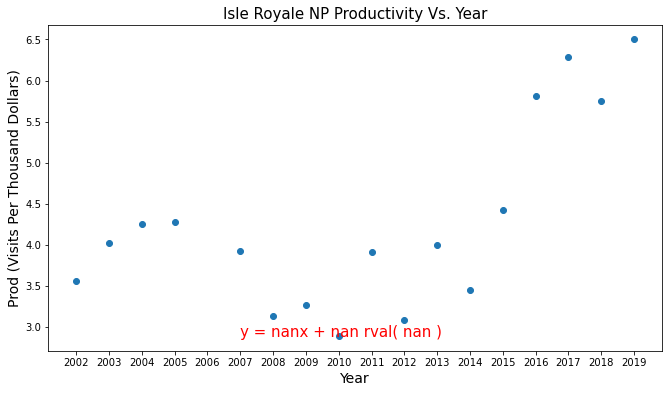

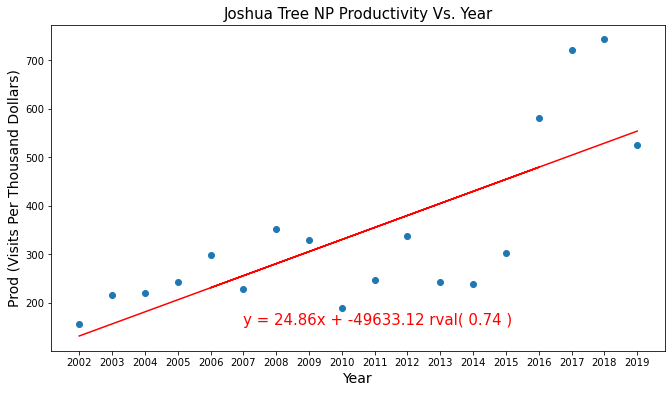

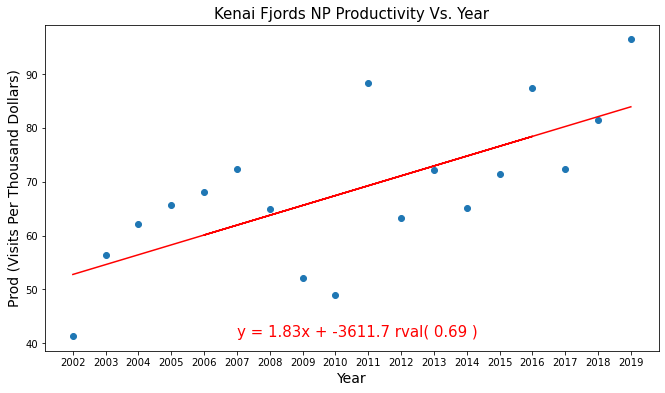

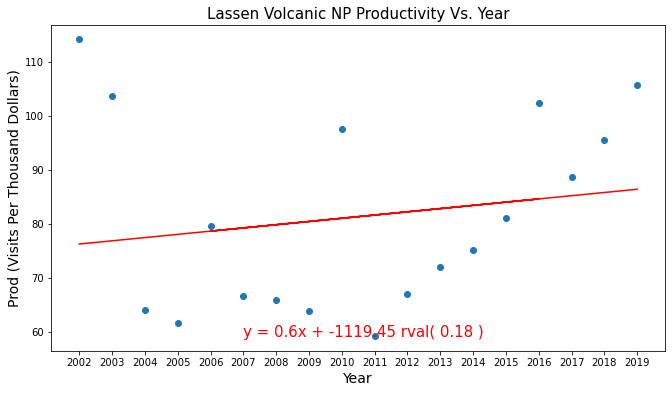

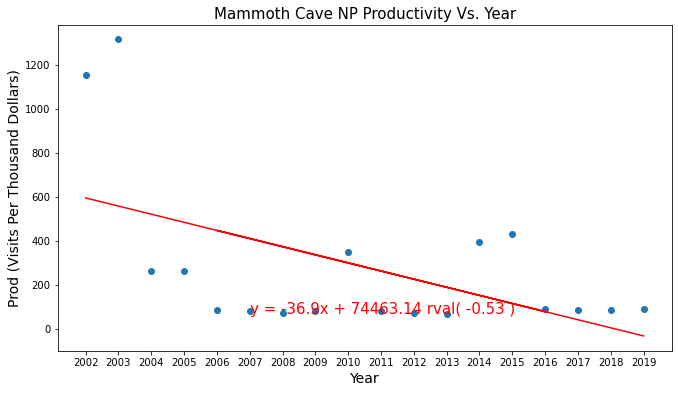

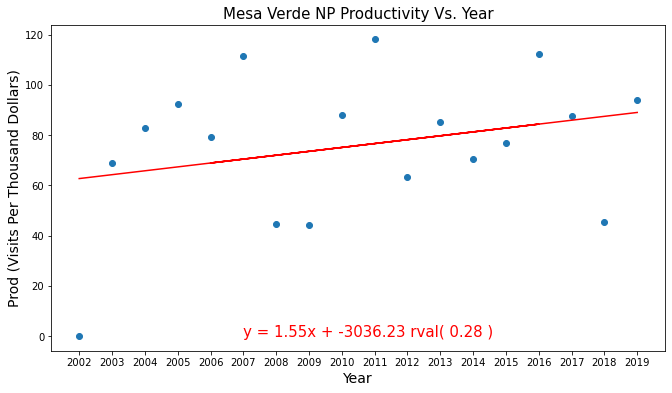

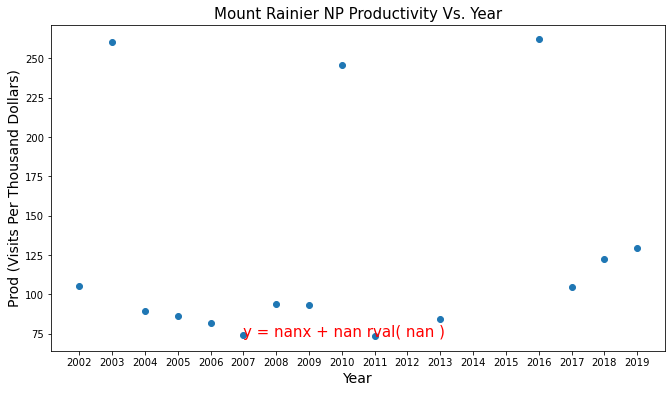

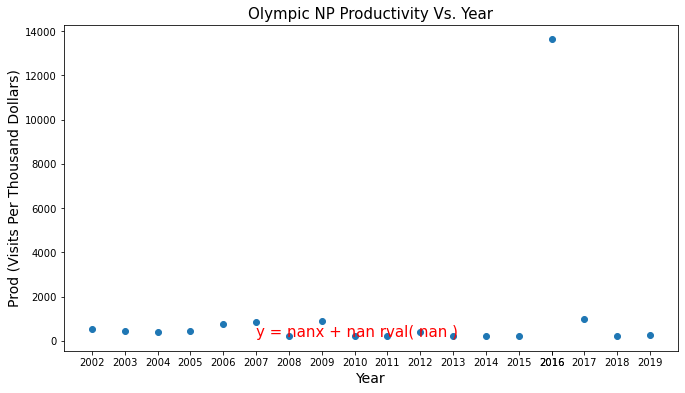

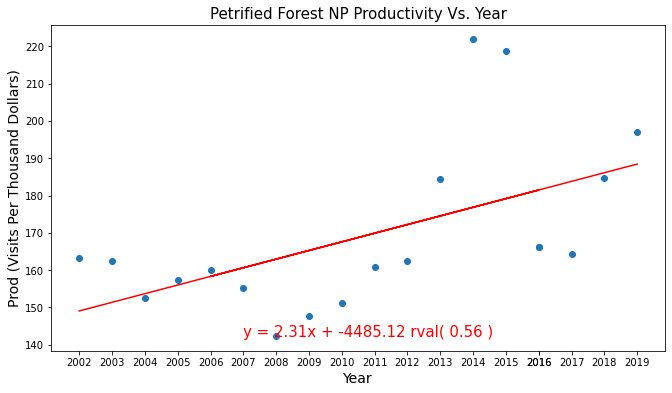

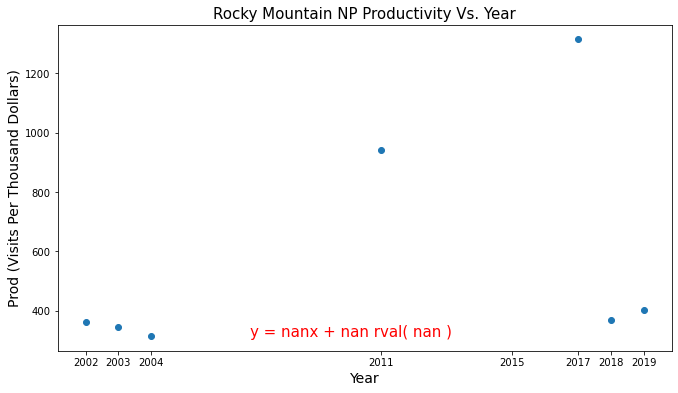

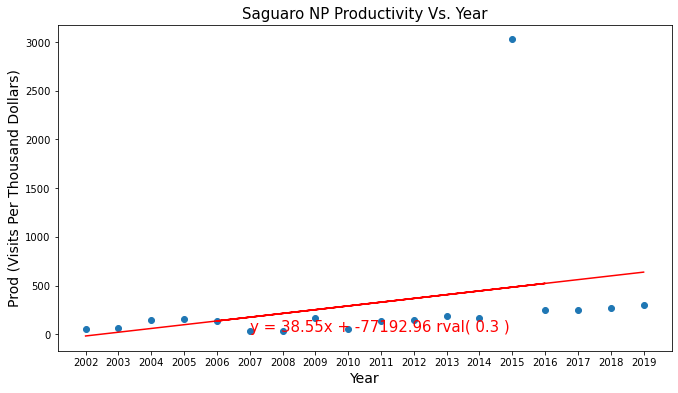

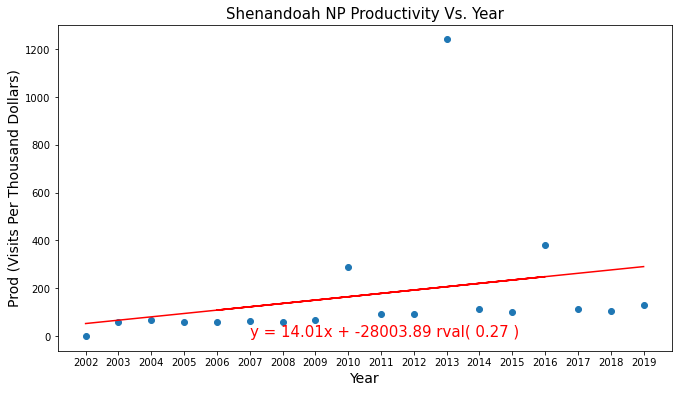

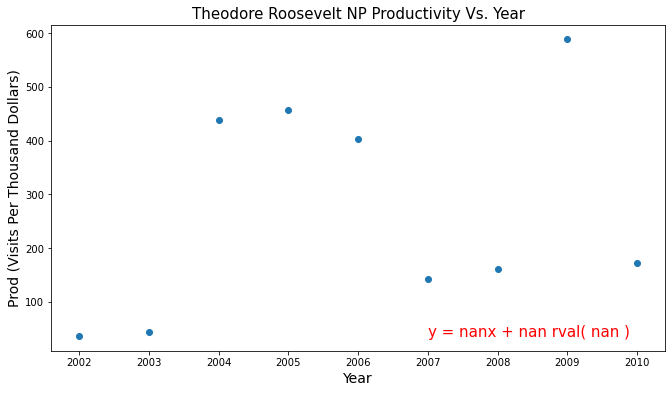

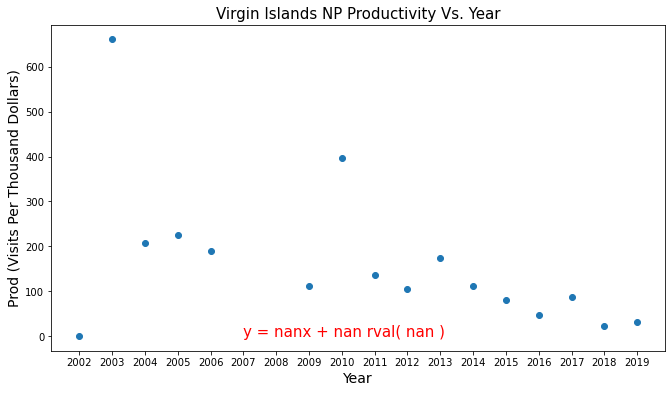

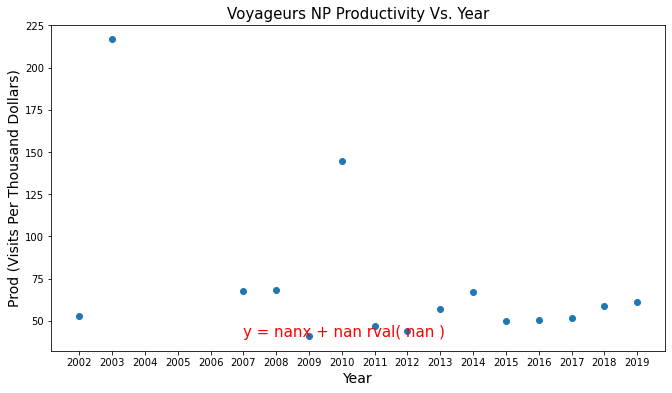

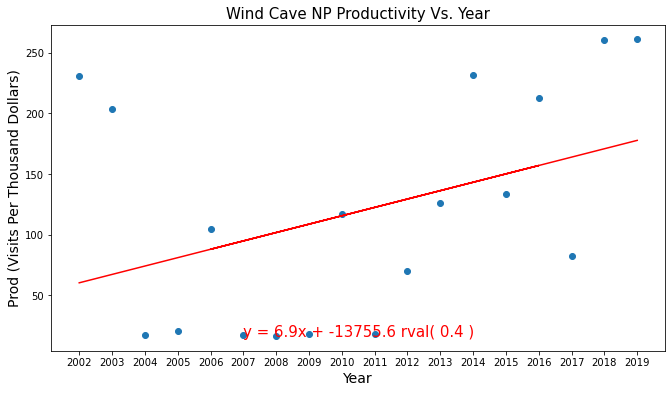

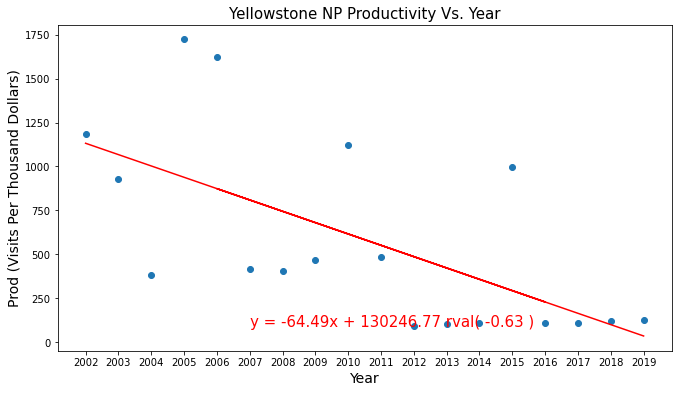

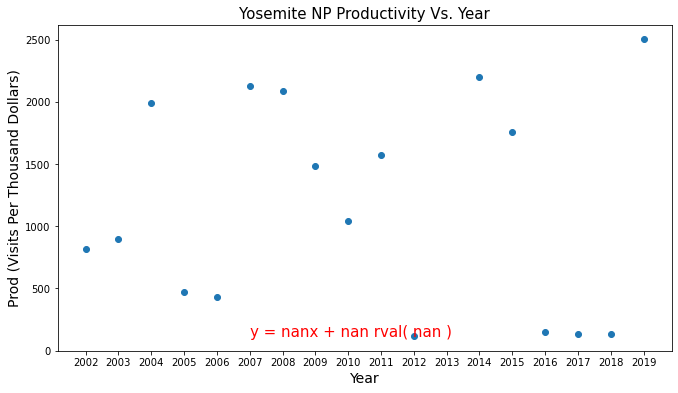

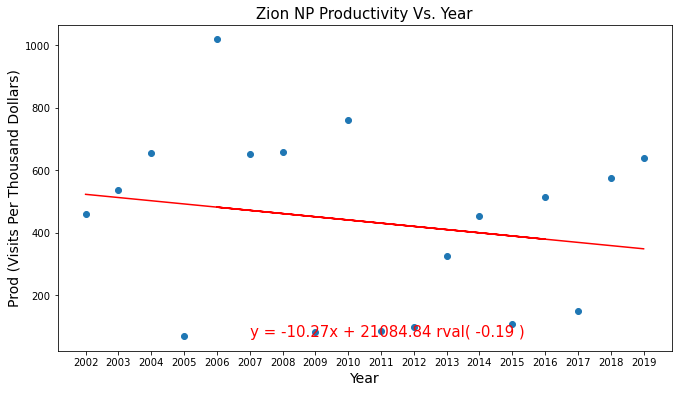

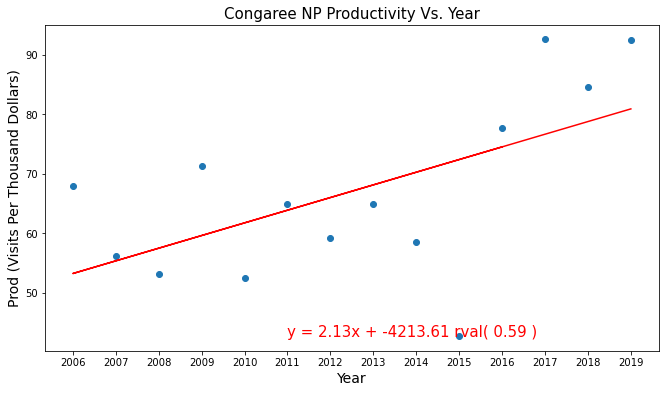

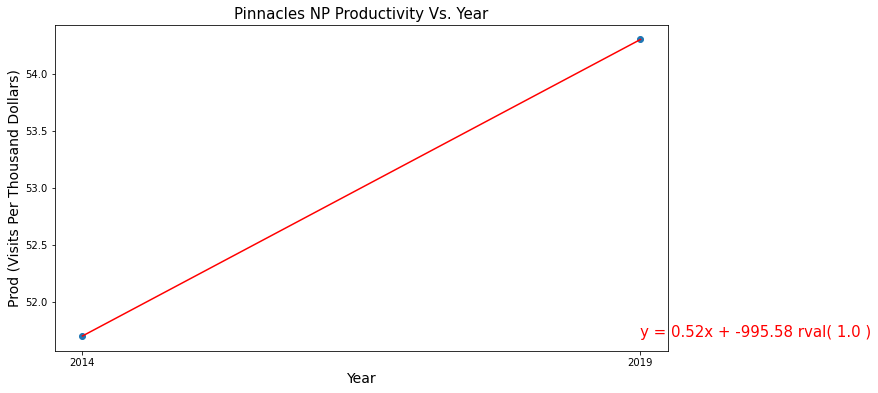

In [59]:
#Generate scatter/line charts for all national parks save rvalues and slopes into DataFrame Productivity_det_regression_df
parks = Productivity_det_df["Park Name"].unique()
slopes = []
rvals = []
park_names = []
line1 = plt

for park in parks:
    fig = plt 
    fig.figure(figsize=(11,6))
    line1 = plt
    x_vals = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Year"]
    y_vals = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Prod (Visits Per Thousand Dollars)"]
    ylim_top = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Prod (Visits Per Thousand Dollars)"].max() + 10
    ylim_bottom = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Prod (Visits Per Thousand Dollars)"].min() - 5
    xmin = Productivity_det_df[Productivity_det_df["Park Name"] == park]["Year"].min()
    park_names.append(park)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
    slopes.append(slope)
    rvals.append(rvalue)
    regress_values = x_vals * slope + intercept
    line_formula = f'y = {str(round(slope,2))}x + {str(round(intercept,2))} rval( {round(rvalue,2)} )'
    line1.annotate(line_formula,xy=(xmin + 5,ylim_bottom + 5),fontsize=15,color="red")
    fig.scatter(x=x_vals, y=y_vals, marker='o')
    fig.ylabel("Prod (Visits Per Thousand Dollars)",fontsize=14)
    fig.xlabel("Year",fontsize=14)
    fig.xticks(x_vals)
    fig.title(f"{park} Productivity Vs. Year",fontsize=15)
    fig.plot()
    line1.plot(x_vals,regress_values,"r-")
    plt.savefig(output_graphs + f"productivity_{park}.png")
    


Productivity_det_regression_df = pd.DataFrame({"Park Name":park_names,
                                               "rvals":rvals,
                                               "slopes":slopes})

In [53]:
Productivity_det_regression_df

,Park Name,rvals,slopes
0,Acadia NP,0.780379,9.469845
1,Arches NP,0.879155,25.177069
2,Badlands NP,0.445174,1.783674
3,Big Bend NP,0.450091,0.776120
4,Biscayne NP,-0.103093,-1.715624
5,Black Canyon of the Gunnison NP,0.333687,2.960764
6,Bryce Canyon NP,0.903209,32.694974
7,Canyonlands NP,0.681755,3.773416
8,Capitol Reef NP,0.667324,19.489856
9,Carlsbad Caverns NP,0.078364,0.416223
